# (PINN) -> 

# Example n = 0 polytropique -> 
# Used to make figures 3 and 4 in Paper Astronomy&Computing
## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# ................

def solut(x):
    # .........................
    y = 1. - 1./6*x*x   
    # n = 0 Exact solution ....    
    return y

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true solution.


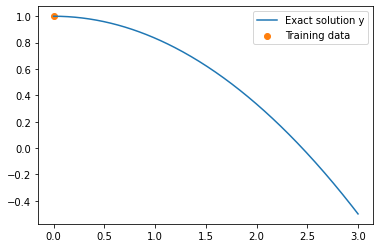

In [3]:
# get the analytical solution over the full domain
x = torch.linspace(0,3,300).view(-1,1)
y = solut(x).view(-1,1)
x = x[::1]
y = y[::1]

# ... slicing the true solution at x=0
x_data=x[0:300:300]
y_data=y[0:300:300]

# The sole data used is the boundary one at x = 0 ...
y_data[0]=1.

plt.figure()
plt.plot(x, y, label="Exact solution y")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()


## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

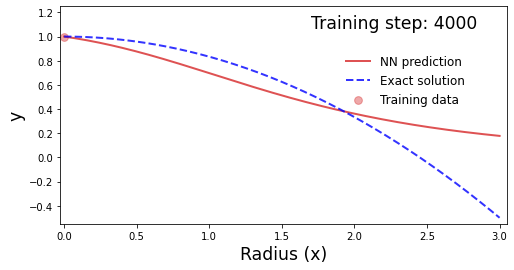

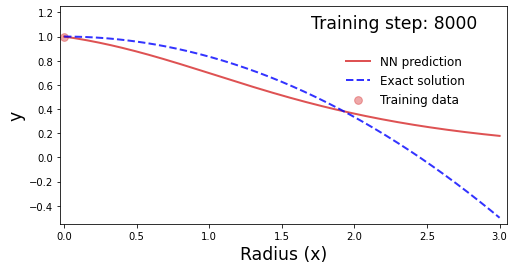

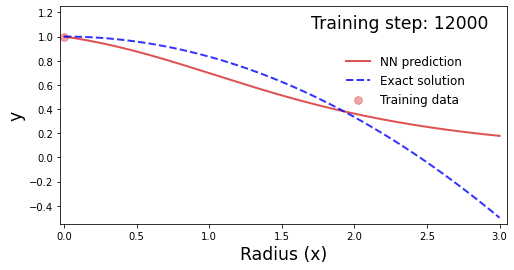

In [5]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Collocation points')
    l = plt.legend(loc=(0.63,0.52), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.025, 3.05)
    plt.ylim(-0.55, 1.25)
    plt.text(1.7,1.07,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Radius (x)',fontsize="xx-large")
    plt.axis("on")
        
# train standard neural network to fit training data ..................
# But with only one data (at x=0), obviously it does not work ........
torch.manual_seed(123)
model = FCN(1,1,20,2)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []
loss11_history = []

for i in range(12000):
    optimizer.zero_grad()
    yh = model(x_data)
  
    loss = torch.mean((yh-y_data)**2)  # use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses ......................
    if (i+1) % 100 == 0: 
        loss11_history.append(loss.detach())  
        yh = model(x).detach()
              
        plot_result(x,y,x_data,y_data,yh)
        
    
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")
            


## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at ...

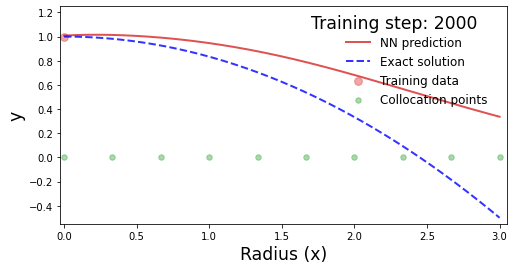

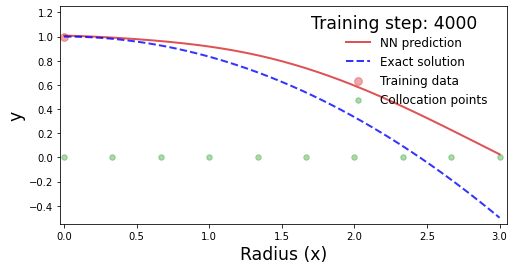

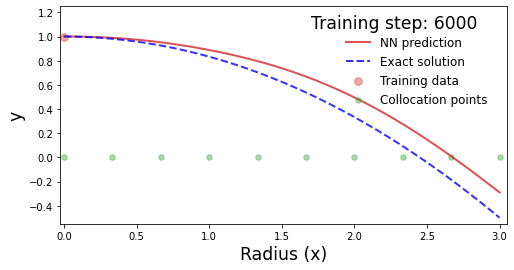

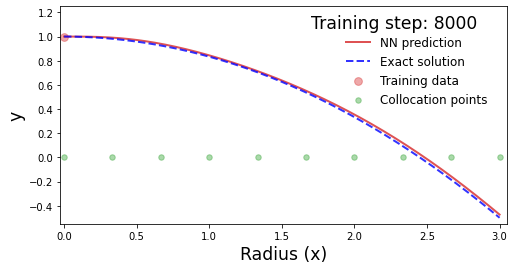

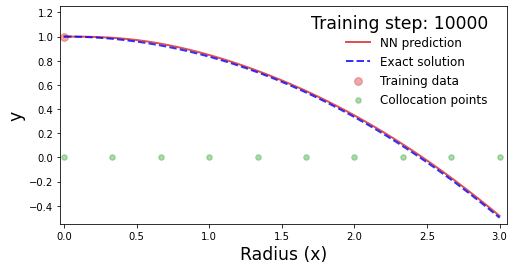

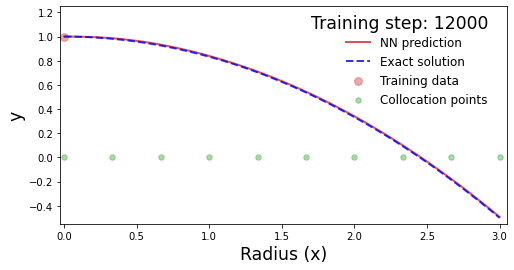

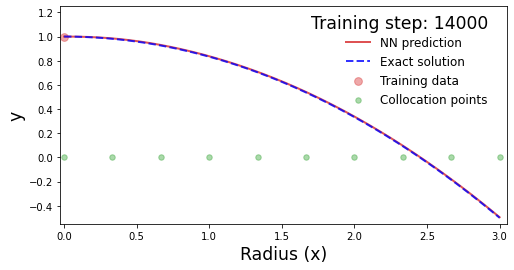

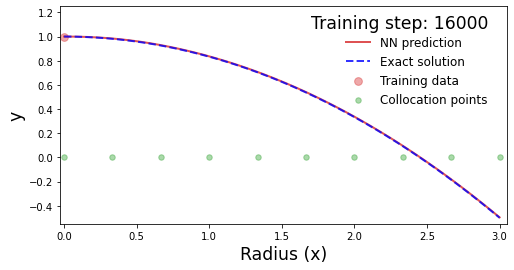

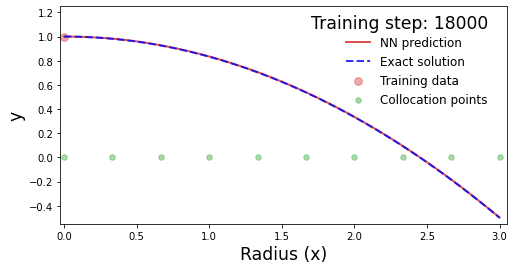

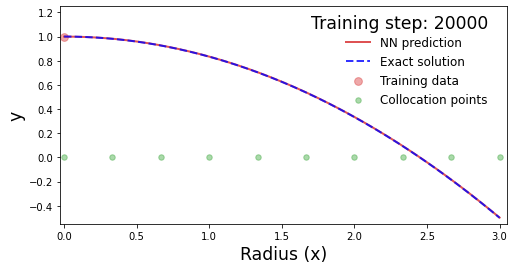

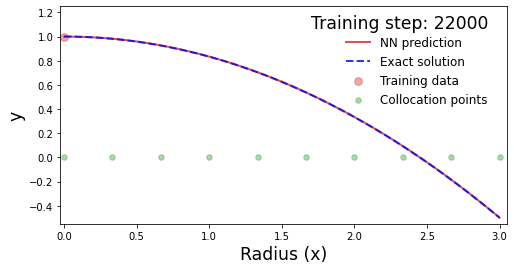

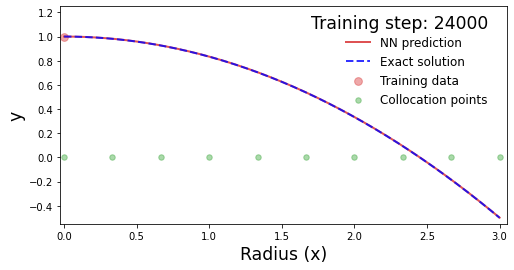

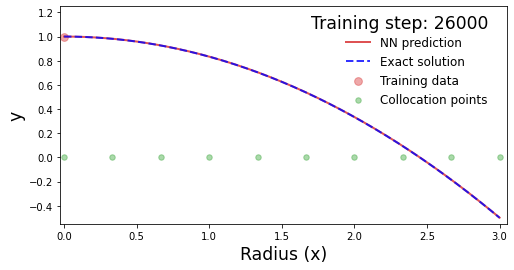

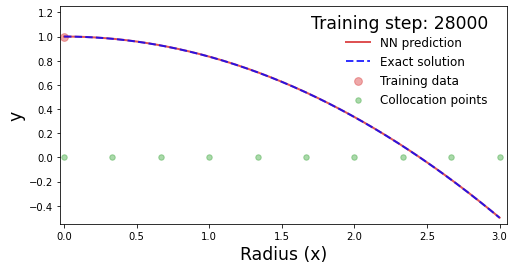

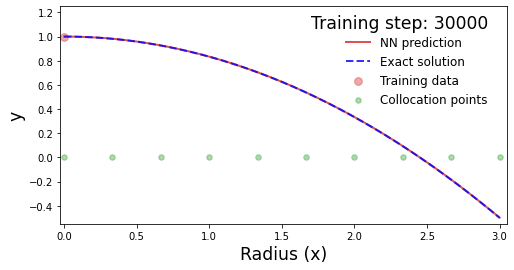

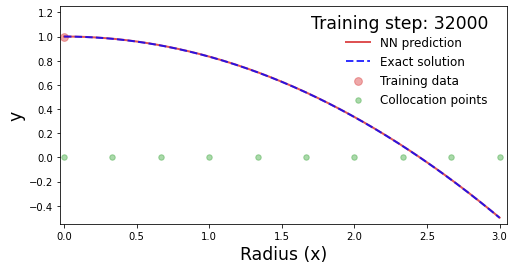

In [6]:
# We choose the colocation points for physics in the interval [0:3] ....
x_physics = torch.linspace(0,3,10).view(-1,1).requires_grad_(True)# sample locations over the problem domain

# the polytropic index is indic=0 for this case .....
indic=0

# We initialize pseudo-randomly the hyper-parameters ... note that it could influence the details of the results
# if you modify the value between parenthesis ..............
torch.manual_seed(127)

# we choose two hidden layers with 20 neurons per layer ...
model = FCN(1,1,20,2)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []

loss_history = []
loss2_history = []
loss1_history = []
mse_history =[]

# Training process with 32000 epochs ................................
for i in range(32000):
    
    optimizer.zero_grad()    
    # We compute the "training data loss"  -> only the value at x= 0 .............
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)# use mean squared error .............
      
    # We compute the "physics loss" .............................................
    yhp = model(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  
    dxx = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0] 
    
    # The training data loss is modified to take into account the zero first derivative at x=0 ...
    # and an arbitrary weight is used that can be tuned .............
    loss1 = loss1 + 0.01*torch.mean((dx[0]-0)**2)
      
    physics = x_physics*dxx + 2*dx + x_physics*yhp**indic    
    
    # This is the physics loss with weight 0.02 ..........
    loss2 = (2e-2)*(torch.mean(physics**2))
    
    # We backpropagate total loss ................................................
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
        
    # We plot the result as training progresses ..................................
    if (i+1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())
        loss1_history.append(loss1.detach())
    
        yh = model(x).detach()
        xp = x_physics.detach()        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        mse= torch.mean((yh-y)**2)
        mse_history.append(mse.detach())
        
        if (i+1) % 2000 == 0: plt.show()
        else: plt.close("all")
            
            

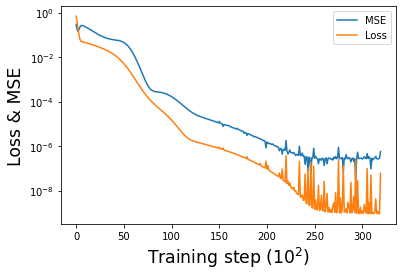

In [33]:
# We plot the total loss and MSE with predicted values using 300 points (see beginning of the code)
plt.plot(mse_history,label='MSE')
plt.plot(loss_history,label='Loss')
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.ylabel('Loss & MSE',fontsize="xx-large")
plt.yscale('log')
plt.legend()

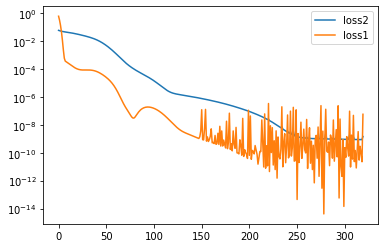

In [34]:
# We plot the two partial losses ............
plt.plot(loss2_history, label="loss2")
plt.plot(loss1_history, label="loss1")
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'Absolute error')

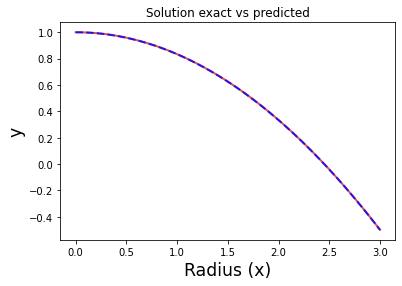

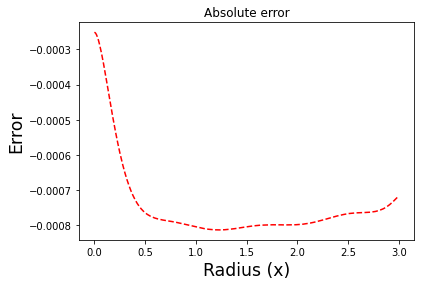

In [35]:
# We compare with exact solution ..........
xn = torch.linspace(0,3.,300).view(-1,1)
ypre = model(xn).detach()

# plot extrapolate    
fig5 = plt.figure(5)
plt.plot(xn, ypre,color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
plt.plot(xn, y,color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact solution")
plt.ylabel('y',fontsize="xx-large")
plt.xlabel('Radius (x)',fontsize="xx-large")
plt.title("Solution exact vs predicted")

fig6 = plt.figure(6)
plt.plot(xn, y-ypre,'r--')
plt.ylabel('Error',fontsize="xx-large")
plt.xlabel('Radius (x)',fontsize="xx-large")
plt.title("Absolute error")

In [36]:
# We print the average squared error ......
print (torch.mean(y-ypre)**2)

tensor(5.5811e-07)
